## Looking into survival analysis

This notebook is based on the introduction of scikit-survival see [docs](https://scikit-survival.readthedocs.io/en/latest/)
The idea is to add further notes regarding to model evaluation and examples of other models / datasets.

In survival analysis we attempt to find a relation between between parameters and the moment/time of an event. However the event may not occur in all observations. 
If the event is a death of a subject, some subjects will persist beyond the scope of the study or will opt out of the study before its conclusion. 

Survival analysis tries to deal with this type of incomplete data. Above the event chosen was classicly death, but could also mean epileptic seizure, or in engineering the moment a part breaks, or in HR when an employee quits.

In [55]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.preprocessing import OneHotEncoder


from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.compare import compare_survival
from sksurv.metrics import concordance_index_censored

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data_x, data_y = load_veterans_lung_cancer()


## Y in survival data
For survival models to run properly it expects a number which represents a unit of time, (e.g. days, weeks, months) and whether the case / observation ends in an event (e.g. death) 
or is censored (as in we do not know what happened from this point onwards), study's observation period ended, subjects opted out etc. 
It is written as the *event* of interest occurred (True) or not (False).

In [62]:
# Examples of events and at which timepoint, as well as censored data and at which timepoint
data_y[:10]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [4]:
data_x.columns

Index(['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis',
       'Prior_therapy', 'Treatment'],
      dtype='object')

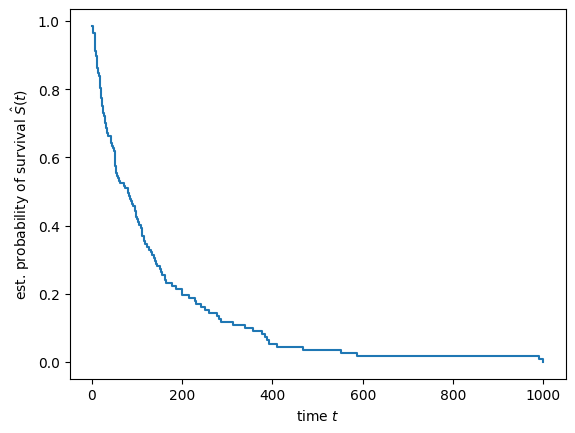

In [10]:
time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [11]:
## Looking at treatment
data_x["Treatment"].value_counts()


standard    69
test        68
Name: Treatment, dtype: int64

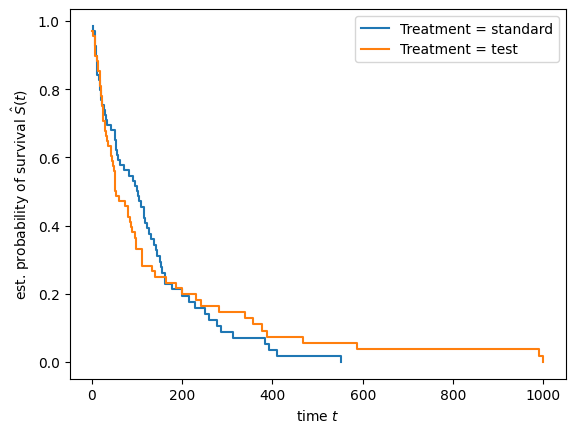

In [12]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [25]:
# Performing log-rank test to determine treatment effect
stats = compare_survival(data_y,data_x["Treatment"], return_stats=True)
stats

(0.008227343202350305,
 0.9277272333400758,
           counts  observed   expected  statistic
 group                                           
 standard      69        64  64.500197  -0.500197
 test          68        64  63.499803   0.500197,
 array([[ 30.4103884, -30.4103884],
        [-30.4103884,  30.4103884]]))

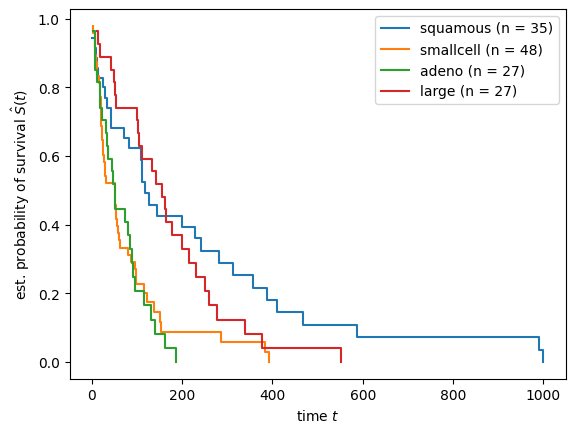

In [19]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [22]:
data_x["cell_group"] = data_x["Celltype"].apply(lambda x: 1 if x in ["squamous", "large"] else 0)

In [26]:
stats = compare_survival(data_y,data_x["cell_group"], return_stats=True)
stats

(24.524185922668472,
 7.338289632999644e-07,
        counts  observed   expected  statistic
 group                                        
 0          75        71  45.795844  25.204156
 1          62        57  82.204156 -25.204156,
 array([[ 25.9029794, -25.9029794],
        [-25.9029794,  25.9029794]]))

In [30]:
## Multivariate models

In [38]:
data_x.drop(columns=["cell_group"], inplace=True)

In [56]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

Age_in_years  Celltype=large  Celltype=smallcell  Celltype=squamous  \
0          69.0             0.0                 0.0                1.0   
1          64.0             0.0                 0.0                1.0   
2          38.0             0.0                 0.0                1.0   
3          63.0             0.0                 0.0                1.0   
4          65.0             0.0                 0.0                1.0   

   Karnofsky_score  Months_from_Diagnosis  Prior_therapy=yes  Treatment=test  
0             60.0                    7.0                0.0             0.0  
1             70.0                    5.0                1.0             0.0  
2             60.0                    3.0                0.0             0.0  
3             60.0                    9.0                1.0             0.0  
4             70.0                   11.0                1.0             0.0

In [40]:
set_config(display="text")  # displays text representation of estimators



In [41]:
estimator = CoxPHSurvivalAnalysis()


In [42]:
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [43]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)


Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [ ]:
# Creating synthetic patients for explainability

In [44]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

Age_in_years  Celltype=large  Celltype=smallcell  Celltype=squamous  \
1            65               0                   0                  1   
2            65               0                   0                  1   
3            65               0                   1                  0   
4            65               0                   1                  0   

   Karnofsky_score  Months_from_Diagnosis  Prior_therapy=yes  Treatment=test  
1               60                      1                  0               1  
2               60                      1                  0               0  
3               60                      1                  0               0  
4               60                      1                  0               1

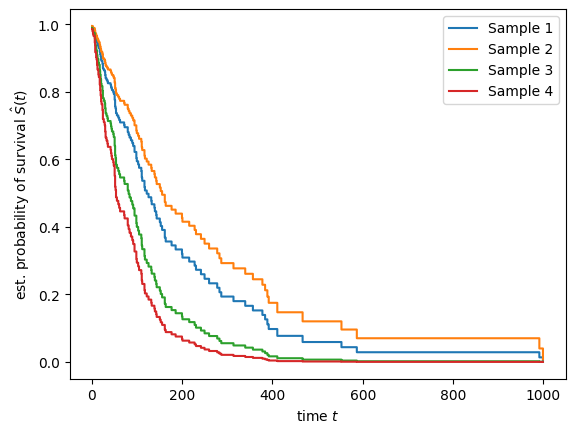

In [47]:
# Plotting the synthetic patients based on predictions according to the model
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [46]:
# Evaulating the model based on AUC-ROC 
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

In [48]:
estimator.score(data_x_numeric, data_y)


0.7362562471603816

In [49]:

def fit_and_score_features(X, y):
    """
    Fit models for each feature to 
    calculate feature contribution
    and identify best risk predictor.
    """
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [52]:
# Which variables do we need?
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [57]:

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

param_select__k            params  split0_test_score  split1_test_score  \
4               5  {'select__k': 5}           0.716093           0.719862   
3               4  {'select__k': 4}           0.697368           0.722332   
7               8  {'select__k': 8}           0.706478           0.723320   
5               6  {'select__k': 6}           0.704453           0.719368   
6               7  {'select__k': 7}           0.700405           0.719368   
1               2  {'select__k': 2}           0.699393           0.717885   
0               1  {'select__k': 1}           0.698887           0.707510   
2               3  {'select__k': 3}           0.708502           0.714427   

   split2_test_score  mean_test_score  std_test_score  rank_test_score  \
4           0.716685         0.717547        0.001655                1   
3           0.727324         0.715675        0.013104                2   
7           0.716685         0.715494        0.006927                3   
5           0.716685         0.713502        0.006491                4   
6           0.720045         0.713272        0.009103                5   
1           0.718365         0.711881        0.008833                6   
0           0.712206         0.706201        0.005516                7   
2           0.694849         0.705926        0.008198                8   

   split0_train_score  split1_train_score  split2_train_score  \
4            0.732087            0.742432            0.731710   
3            0.732477            0.743090            0.727138   
7            0.739356            0.746249            0.737519   
5            0.735722            0.747565            0.731710   
6            0.741173            0.742564            0.728621   
1            0.732087            0.727428            0.714409   
0            0.710670            0.714793            0.700445   
2            0.734034            0.722559            0.716634   

   mean_train_score  std_train_score  
4          0.735410         0.004968  
3          0.734235         0.006630  
7          0.741041         0.003758  
5          0.738332         0.006731  
6          0.737453         0.006271  
1          0.724642         0.007481  
0          0.708636         0.006032  
2          0.724409         0.007223

In [58]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64